In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
def extract_last_two_numbers(file_path):
    orig = []
    adv = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                last_two = parts[-2:]  # Get the last two elements
                orig.append(float(last_two[0]))
                adv.append(float(last_two[1]))
    return orig, adv


In [8]:
with open("config.json", "r") as f:
    config = json.load(f)

In [13]:
results_dict = {
    heatmap_type: {
        metric: {"orig": [], "adv": []}
        for metric in config["distance_metrics"]
    }
    for heatmap_type in config["saliency_map"]
}
attack_type = "PGD"
def plot_histograms(attack_type, saliency_type):    
    res_dir = "results"


    for saliency_type in config["saliency_map"]:
        for distance_metric in config["distance_metrics"]:
            orig, adv = extract_last_two_numbers(f"{res_dir}/{attack_type}_{saliency_type}_{distance_metric}.txt")
            results_dict[saliency_type][distance_metric]["orig"] = orig
            results_dict[saliency_type][distance_metric]["adv"] = adv
            plt.figure()
            plt.hist(orig, bins=30, alpha=0.5, label="original", color="blue")
            plt.hist(adv, bins=30, alpha=0.5, label="Adversarial", color="red")
            plt.xlabel("Distance Value")
            plt.ylabel("Frequency")
            plt.title(f"saliency map: {saliency_type}, distance: {distance_metric}")
            plt.legend()
            plt.show()

In [10]:
from sklearn.metrics import roc_curve, auc

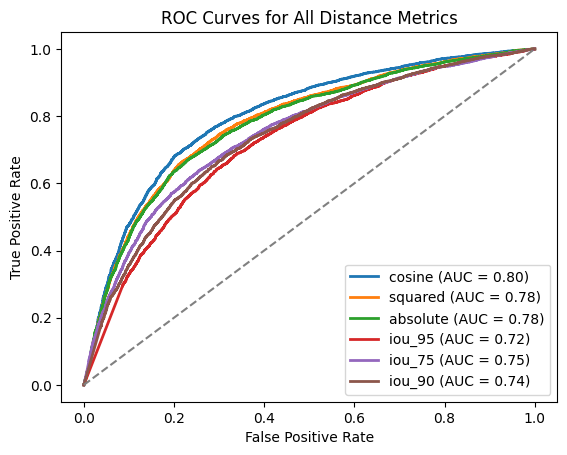

In [ ]:
# Create a figure for all ROC curves
# plt.figure()

# Iterate over each distance metric and calculate the ROC curve
for saliency_method in config["saliency_map"]:
    for distance_metric in config["distance_metrics"]:
        orig = results_dict[saliency_method][distance_metric]["orig"]
        adv = results_dict[saliency_method][distance_metric]["adv"]

        # For some distance metrics, we need to invert the scores
        if distance_metric  not in ["squared", "absolute"]:
            orig = [-x for x in orig]
            adv = [-x for x in adv]

        y_true = np.array([0] * len(orig) + [1] * len(adv))
        
        # Concatenate the scores (distance values)
        y_scores = np.array(orig + adv)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for each distance metric
        plt.plot(fpr, tpr, lw=2, label=f"{distance_metric} (AUC = {roc_auc:.2f})")

    # Plot the diagonal line for reference (random classifier)
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

    # Customize the plot
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for {saliency_method}")
    plt.legend(loc="lower right")

    # Show the plot
    plt.show()